In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import metrics 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = './'
FILENAME = 'Crop_recommendation.csv'
data = pd.read_csv(PATH+FILENAME)

In [3]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
# Calculate the statistics
minimum = data.min()
maximum = data.max()
mean    = data.mean()
median  = data.median()
std_dev = data.std()

# Print the statistics
print("Minimum:\n", minimum)
print("\nMaximum:\n", maximum)
print("\nMean:\n", mean)
print("\nMedian:\n", median)
print("\nStandard deviation:\n", std_dev)

Minimum:
 N                      0
P                      5
K                      5
temperature     8.825675
humidity        14.25804
ph              3.504752
rainfall       20.211267
label              apple
dtype: object

Maximum:
 N                     140
P                     145
K                     205
temperature     43.675493
humidity        99.981876
ph               9.935091
rainfall       298.560117
label          watermelon
dtype: object

Mean:
 N               50.551818
P               53.362727
K               48.149091
temperature     25.616244
humidity        71.481779
ph               6.469480
rainfall       103.463655
dtype: float64

Median:
 N              37.000000
P              51.000000
K              32.000000
temperature    25.598693
humidity       80.473146
ph              6.425045
rainfall       94.867624
dtype: float64

Standard deviation:
 N              36.917334
P              32.985883
K              50.647931
temperature     5.063749
humidity       2

In [6]:
# for which crops do we have data
crop_names = data['label'].unique()
print(crop_names)

# how many types of crops are there in the dataset
print(data['label'].unique().shape)

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
(22,)


In [7]:
# how many data points do we have per crop
data['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

In [8]:
# do we have missing data
data.isnull().sum()
# nope, all good!

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [9]:
# let's introduce more meaningful labels 
data.rename(columns={'N':'nitrogen','P':'phosphorus','K':'potassium','label':'crop'}, inplace=True)
data.head()

,nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [10]:
# create variables that define what our dependent and independent variables are
features = ['nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall']
target = ['crop']
# let's split the data up into features and labels
X = data[features]
y = data[target]

In [11]:
# test size defaults to 25% of whole dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25)

In [12]:
for ii, col in enumerate(features):
  print('{} (min,max): \t \t {:.2f} {:.2f}'.format(col,data[col].min(),data[col].max()))

nitrogen (min,max): 	 	 0.00 140.00
phosphorus (min,max): 	 	 5.00 145.00
potassium (min,max): 	 	 5.00 205.00
temperature (min,max): 	 	 8.83 43.68
humidity (min,max): 	 	 14.26 99.98
ph (min,max): 	 	 3.50 9.94
rainfall (min,max): 	 	 20.21 298.56


In [13]:
# scale inputs. It's important that we apply the scaling after splitting data into training and test
# Otherwise, we would introduce a bias in the training, as the scaling would depend on the test data which 
# in practice is not available during training
mmscaler = MinMaxScaler() 
X_train = mmscaler.fit_transform(X_train)
X_test = mmscaler.transform(X_test)
# convert labels to numerical values 
y_train = LabelEncoder().fit_transform(np.asarray(y_train).ravel())
y_test = LabelEncoder().fit_transform(np.asarray(y_test).ravel())

In [14]:
for ii, col in enumerate(features):
  print('{} (min,max): \t \t {:.2f} {:.2f}'.format(col,X_train[:,ii].min(),X_train[:,ii].max()))

nitrogen (min,max): 	 	 0.00 1.00
phosphorus (min,max): 	 	 0.00 1.00
potassium (min,max): 	 	 0.00 1.00
temperature (min,max): 	 	 0.00 1.00
humidity (min,max): 	 	 0.00 1.00
ph (min,max): 	 	 0.00 1.00
rainfall (min,max): 	 	 0.00 1.00


In [15]:
# define our model. This is a one-liner, thanks to the powerful machine learning library scikit-learn.
model=RandomForestClassifier()
# fit the model to the training data 
model.fit(X_train,y_train)
# get predictions on the test data 
y_pred=model.predict(X_test)
# print training and test accuracy
print('Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model.predict(X_train))*100,metrics.accuracy_score(y_test,model.predict(X_test))*100))

Training Accuracy: 100.00%, Test Accuracy: 99.82%


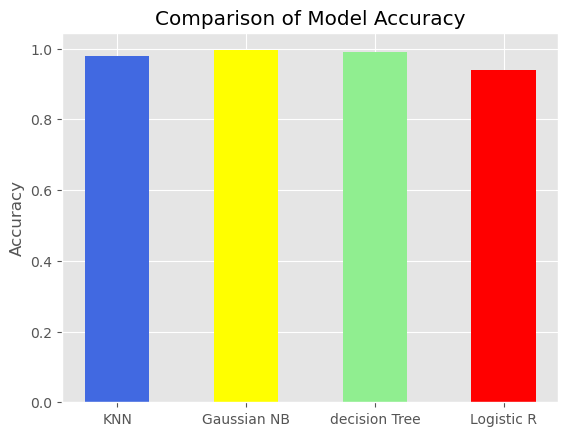

In [16]:
models = ['KNN','Gaussian NB', 'decision Tree','Logistic R']

# create a list of model accuracies
accuracies = [0.98 , 0.995 , 0.99 , 0.94]


# set the plot style
plt.style.use('ggplot')

# set the x-axis labels
x_pos = np.arange(len(models))

# create the bar plot
plt.bar(x_pos, accuracies, color=['Royalblue', 'yellow', 'Lightgreen', 'red'],width= 0.5)

# add the model names as x-axis labels
plt.xticks(x_pos, models)

# set the y-axis label
plt.ylabel('Accuracy')

# set the plot title
plt.title('Comparison of Model Accuracy')

# display the plot
plt.show()

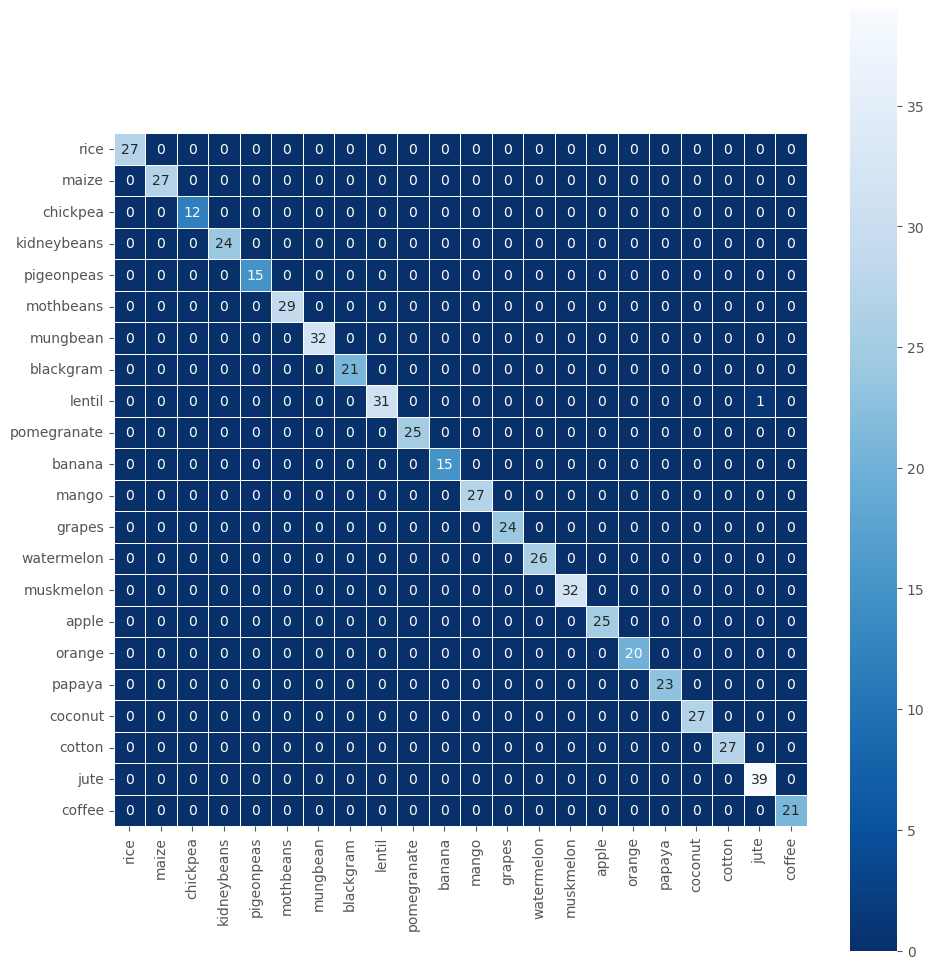

In [17]:
from sklearn.metrics import confusion_matrix
y_pred= model.predict(X_test)
metrics.accuracy_score(y_test,y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_pred,y_test),square=True,cmap='Blues_r',annot=True,fmt=".0f",linewidths=.5)
ax = plt.gca()
_ = ax.set_xticklabels(crop_names,rotation='vertical')
_ = ax.set_yticklabels(crop_names,rotation='horizontal')
plt.tight_layout()

In [18]:
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        21
           8       1.00      0.97      0.98        32
           9       1.00      1.00      1.00        25
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        25
          16       1.00      1.00      1.00        20
          17       1.00    

Training Accuracy: 89.45%, Test Accuracy: 85.64%
there are 100 trees in the forest


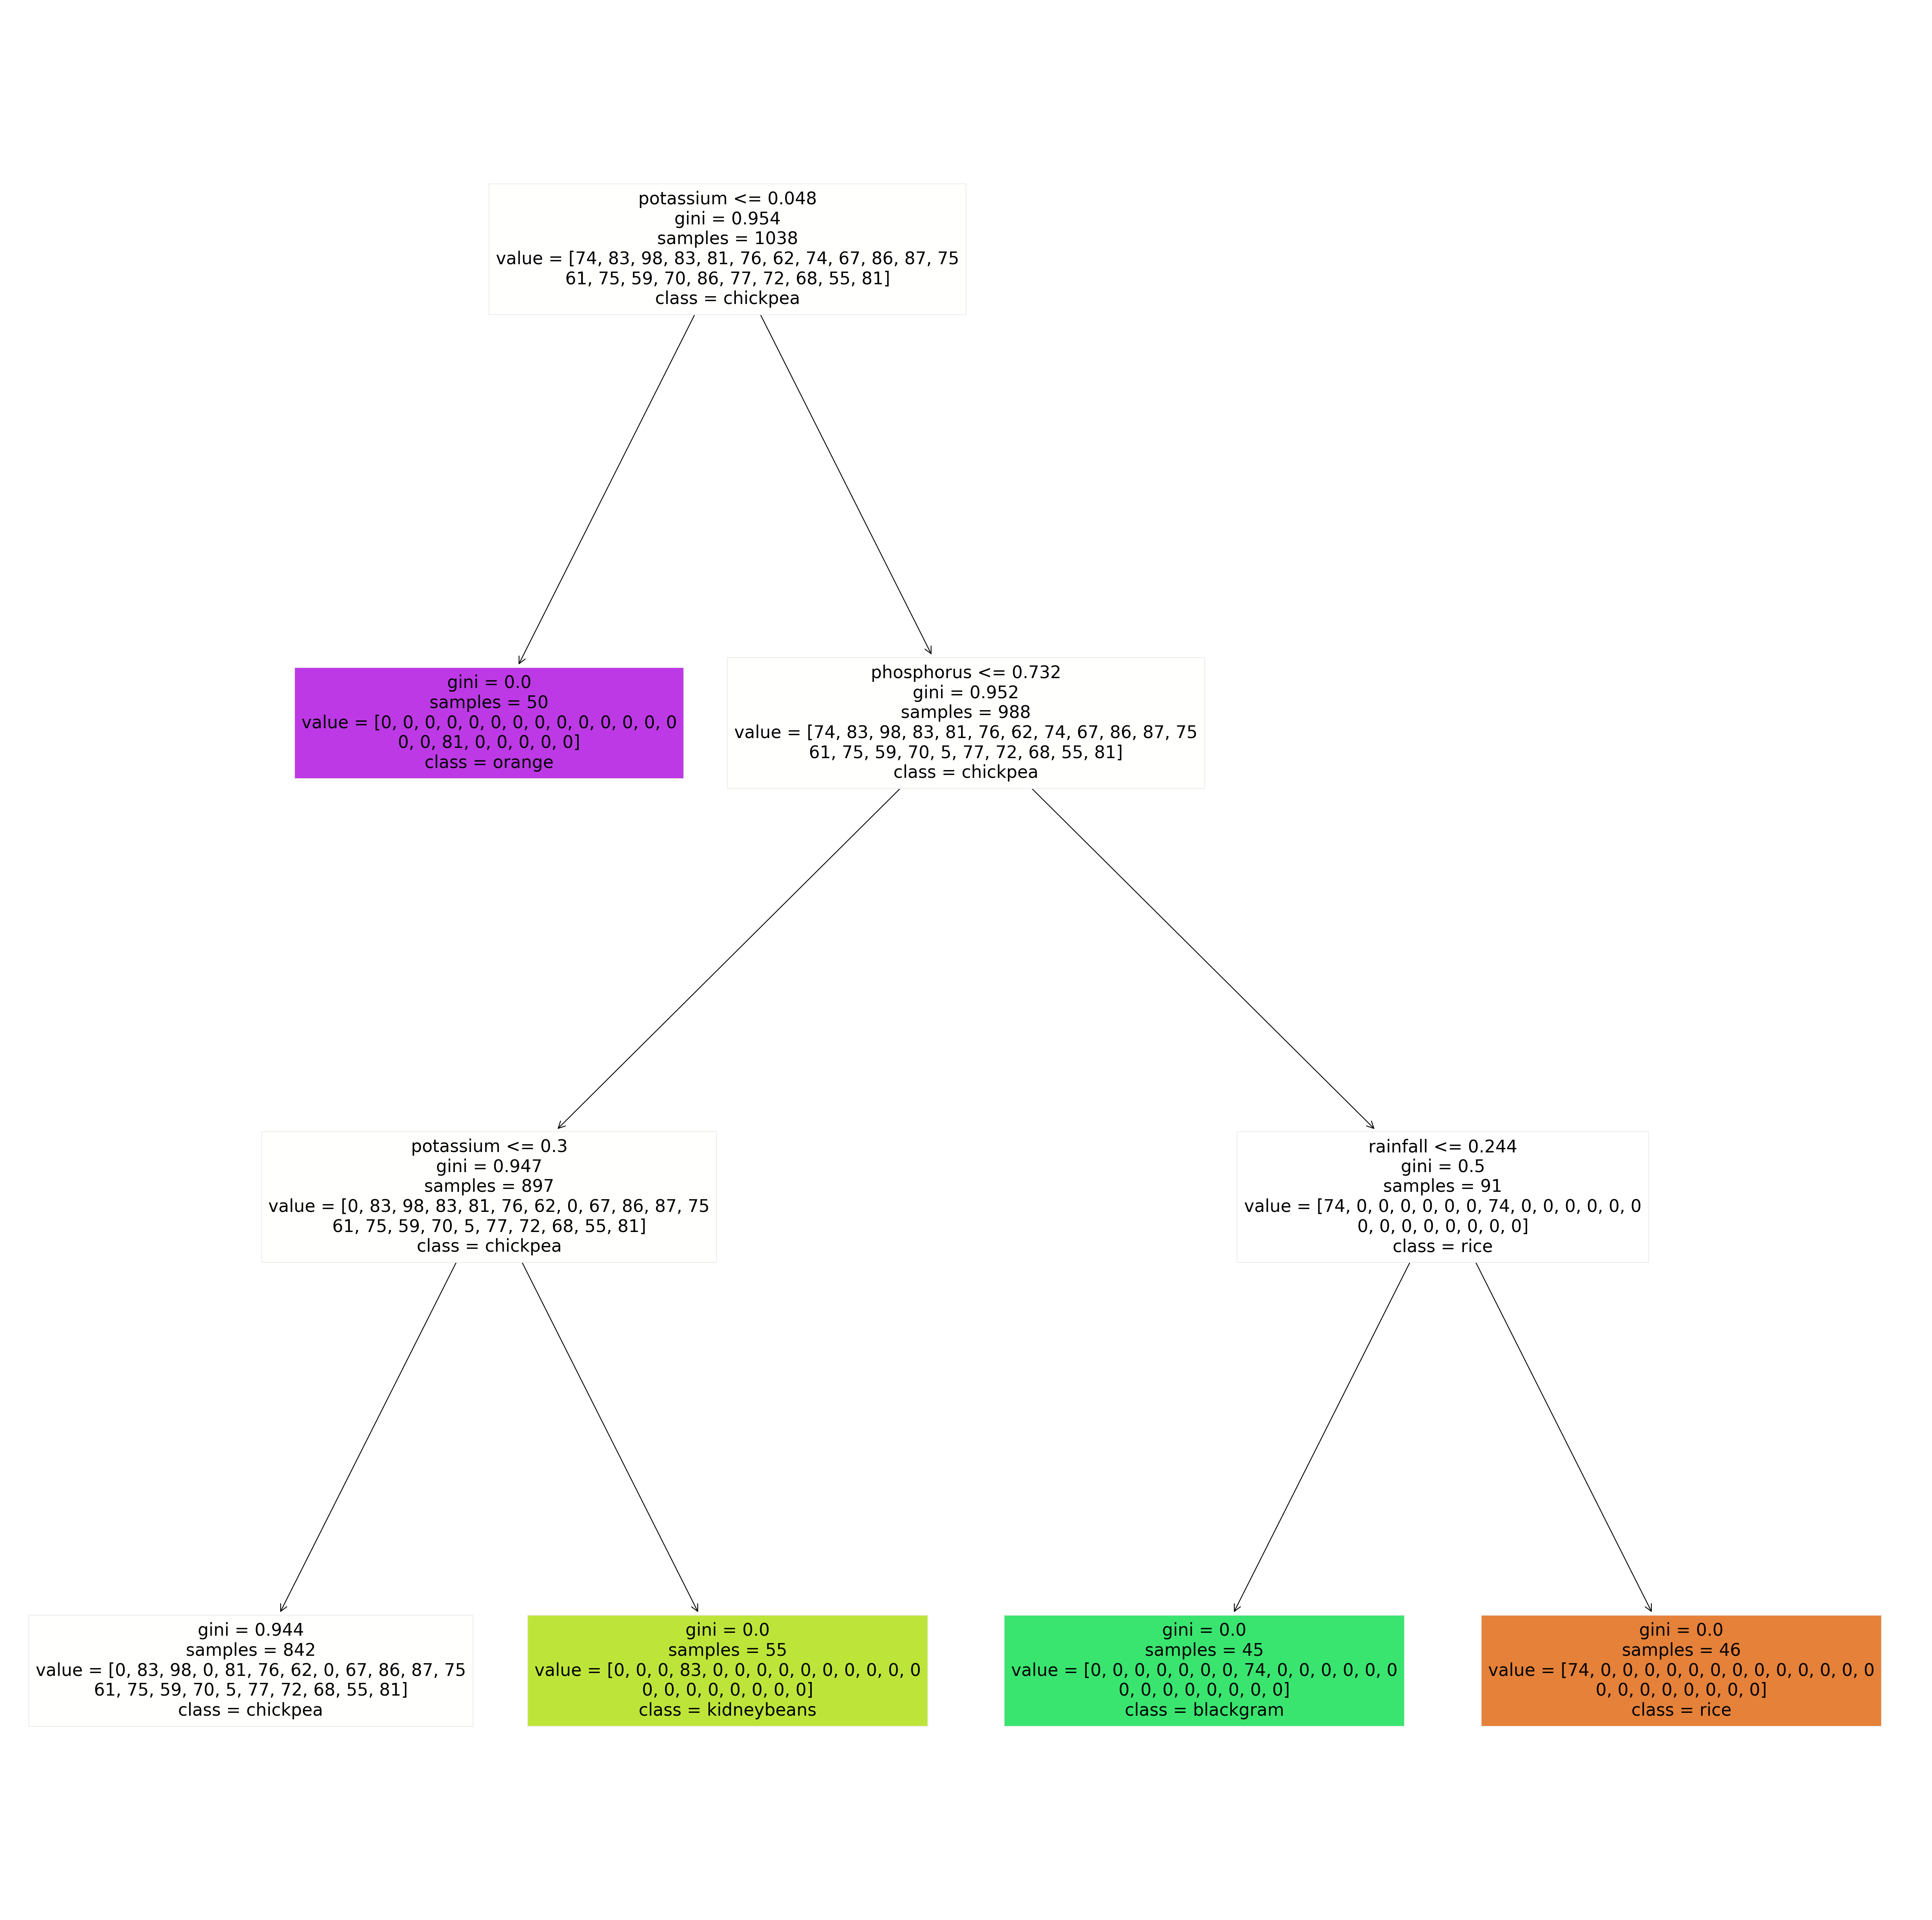

In [19]:
from sklearn import tree

# fit a smaller forest with a maximum depth of 3 (this is how many consecutive 
# decision the algorithm can make). As a consequence, the accuracy will be lower
# but it'll be easier to visualise it
small_rf = RandomForestClassifier(max_depth=3)
# fit the forest to the training data 
small_rf.fit(X_train,y_train)
# get predictions on the test data 
y_pred=small_rf.predict(X_test)
# print training and test accuracy
print('Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,small_rf.predict(X_train))*100,metrics.accuracy_score(y_test,small_rf.predict(X_test))*100))


# obtain list of decision trees
trees = small_rf.estimators_
# how many are there
print('there are {n} trees in the forest'.format(n=len(trees)))

# visualise the first tree 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20),dpi=300)
tree.plot_tree(trees[0],
               feature_names = features, 
               class_names=crop_names,
               filled = True);

In [20]:
import ipywidgets as widgets

In [21]:
def get_predictions(x1,x2,x3,x4,x5,x6,x7):
    feature = mmscaler.transform(np.asarray([x1,x2,x3,x4,x5,x6,x7]).reshape((1,-1)))
    croptoplant = crop_names[model.predict(feature).item()]
    print('{} should grow very well under these conditions'.format(croptoplant.upper()))
    

In [22]:
N = widgets.FloatSlider(min=0.0, max=140.0, value=25.0, step=2.5, description="Nitrogen")
P = widgets.FloatSlider(min=5.0, max=145.0, value=25.0, step=2.5, description="Phosphorus")
K = widgets.FloatSlider(min=5.0, max=205.0, value=25.0, step=2.5, description="Potassium")
temp = widgets.FloatSlider(min=10.0, max=44.0, value=25.0, step=2.5, description="Temperature")
hum = widgets.FloatSlider(min=15.0, max=99.0, value=25.0, step=2.5, description="humidity")
ph = widgets.FloatSlider(min=3.5, max=9.9, value=5.0, step=.5, description="pH")
rain = widgets.FloatSlider(min=20.0, max=298.0, value=25.0, step=2.5, description="Rainfall (mm)")
    
im = widgets.interact_manual(get_predictions,x1=N,x2=P,x3=K,x4=temp,x5=hum,x6=ph,x7=rain)
_ = im.widget.children[-2].description = 'get prediction'
_ = im.widget.children[-2].style.button_color='lightgreen'

display(im)

interactive(children=(FloatSlider(value=25.0, description='Nitrogen', max=140.0, step=2.5), FloatSlider(value=…

<function __main__.get_predictions(x1, x2, x3, x4, x5, x6, x7)>

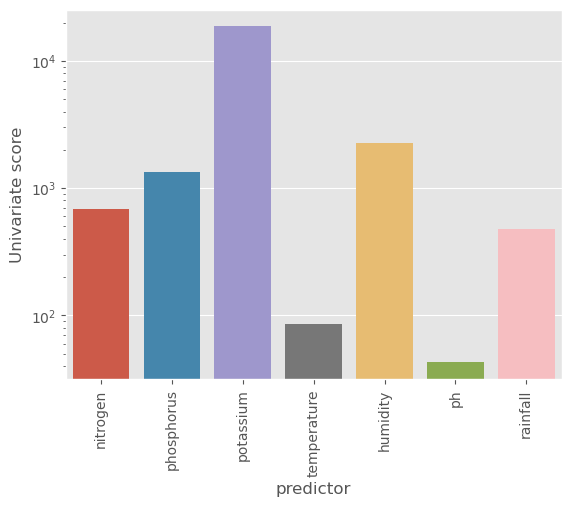

In [77]:
selector = SelectKBest(score_func=f_classif,k='all')
X_train_kbest = selector.fit_transform(X_train,np.asarray(y_train).ravel())
scores = selector.scores_


X_test_kbest = selector.transform(X_test)
mask = selector.get_support() #list of booleans
new_features = [] 
scores = scores[mask==True]
for bool, feature in zip(mask, features):
    if bool:
        new_features.append(feature)
        
_ = sns.barplot(x=new_features,y=scores,log=True)
plt.ylabel('Univariate score')
plt.xlabel('predictor' )
_ = plt.xticks(ticks=np.arange(X_train_kbest.shape[-1]),labels=new_features,rotation='vertical')

In [104]:

selector = SelectKBest(score_func=f_classif,k=5)
X_train_kbest = selector.fit_transform(X_train,np.asarray(y_train).ravel())
scores = selector.scores_


X_test_kbest = selector.transform(X_test)
mask = selector.get_support() #list of booleans
new_features = [] 
scores = scores[mask==True]
for bool, feature in zip(mask, features):
    if bool:
        new_featureeck if it dropped temperature and ph 
        
# check if it dropped temperature and ph        
print(new_features)



# run training and test on reduced dataset 
model_reduced = RandomForestClassifier()
model_reduced.fit(X_train[:,mask],y_train)

# print training and test accuracy
print('all features: Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model.predict(X_train))*100,metrics.accuracy_score(y_test,model.predict(X_test))*100))
print('fewer features: Training Accuracy : {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model_reduced.predict(X_train[:,mask]))*100,metrics.accuracy_score(y_test,model_reduced.predict(X_test[:,mask]))*100))

['nitrogen', 'phosphorus', 'potassium', 'humidity', 'rainfall']
all features: Training Accuracy: 100.00%, Test Accuracy: 99.64%
fewer features: Training Accuracy : 100.00%, Test Accuracy: 99.64%


In [78]:
models = []
models.append(('LogisticRegression',LogisticRegression(max_iter=5000)))
models.append(('DecisionTreeClassifier',DecisionTreeClassifier()))
models.append(('XGBClassifier',XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier()))
models.append(('RandomForestClassifier',RandomForestClassifier()))
models.append(('KNeighborsClassifier',KNeighborsClassifier()))
models.append(('GaussianNB',GaussianNB()))
models.append(('SVM',SVC()))

# same as above, but in cross-validation
nfolds = 5
print('{} fold cv'.format(nfolds))
X_cv = np.asarray(X)
y_cv = LabelEncoder().fit_transform(np.asarray(y).ravel())

for name,model in models:
    # apply transformation to each individual fold
    pipeline = Pipeline([('transformer', MinMaxScaler()), ('estimator', model)])    
    scores = cross_val_score(pipeline, X_cv,y_cv , cv=nfolds)
    print(name, np.round(scores.mean(),3))

5 fold cv
LogisticRegression 0.94
DecisionTreeClassifier 0.987
XGBClassifier 0.992
GradientBoostingClassifier 0.991
RandomForestClassifier 0.993
KNeighborsClassifier 0.98
GaussianNB 0.995
SVM 0.983
